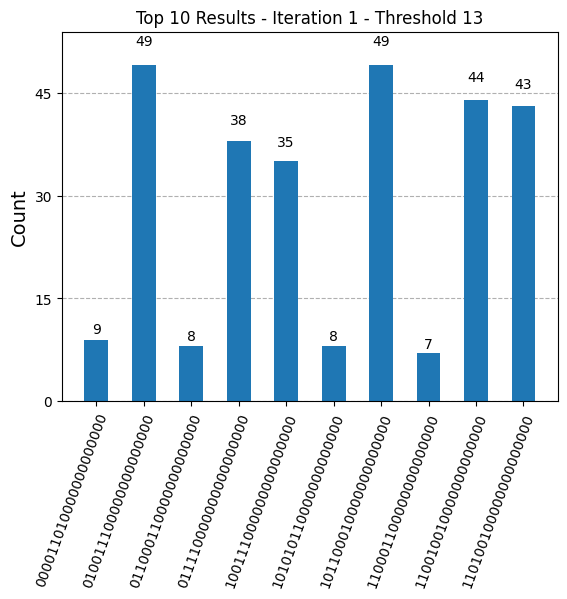

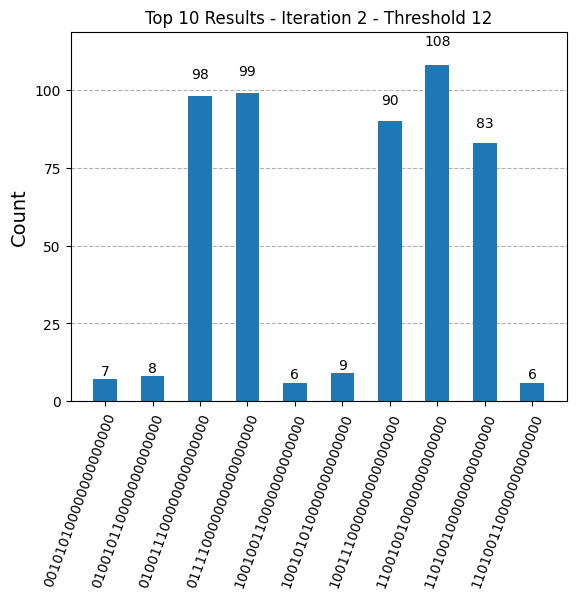

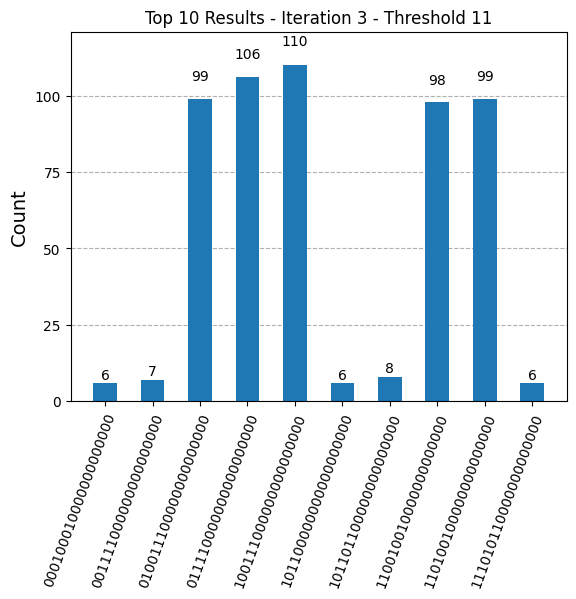

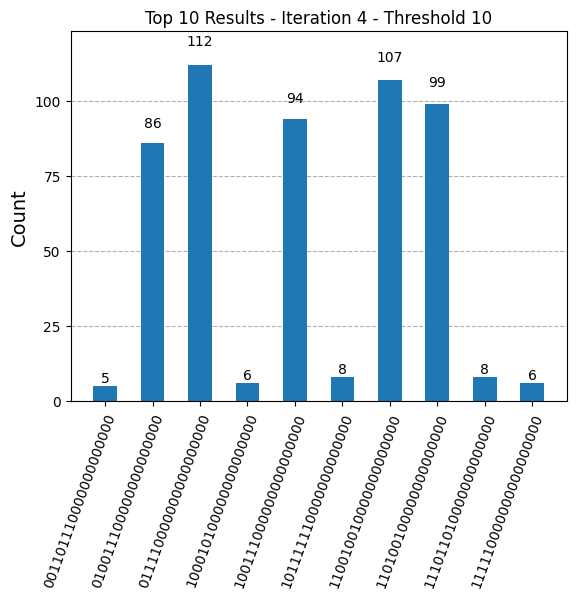

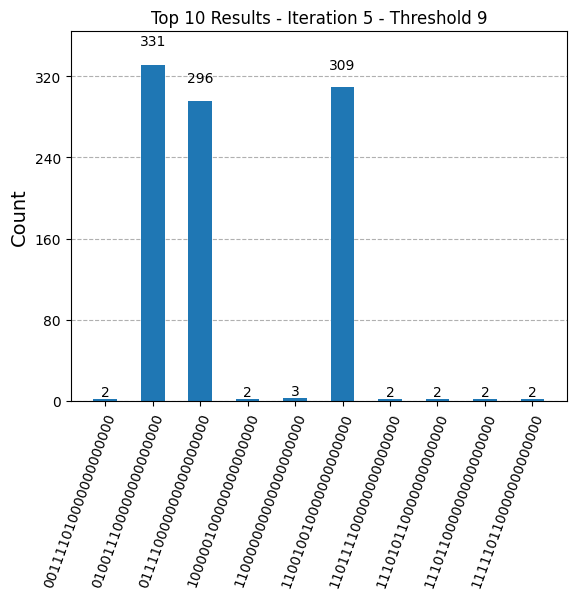

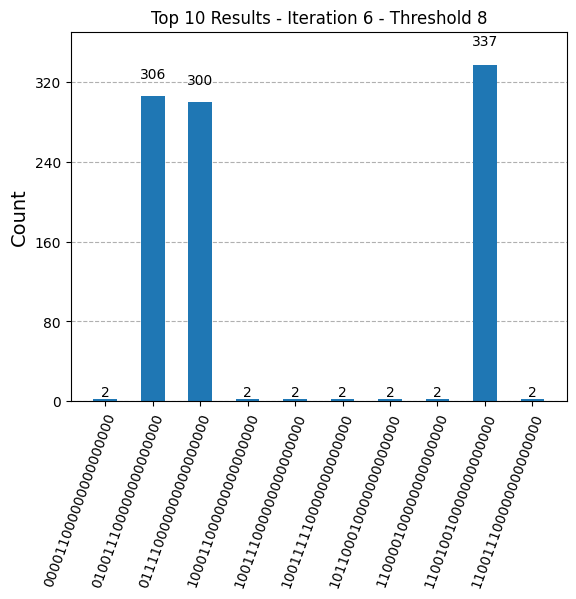

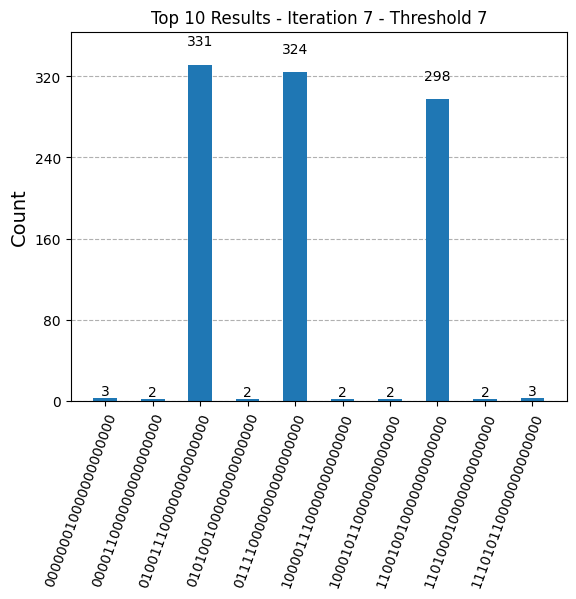

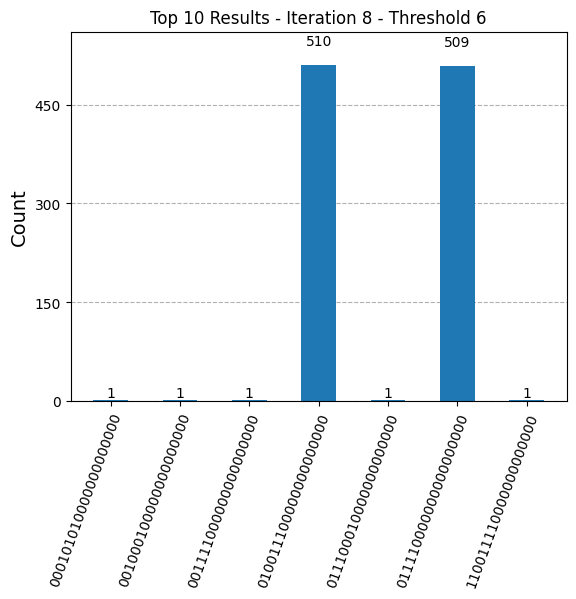

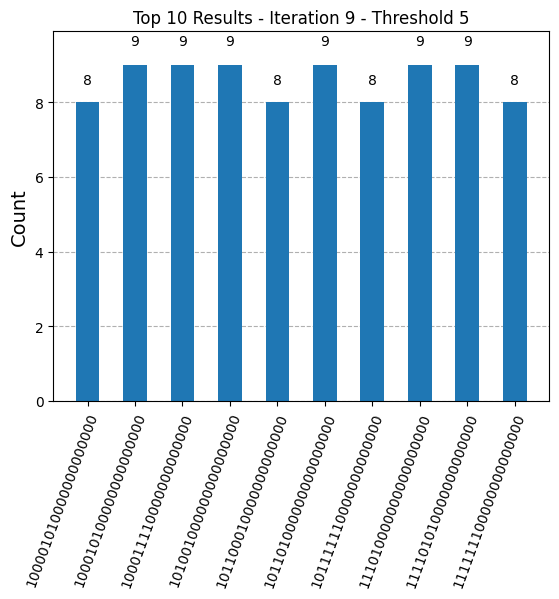

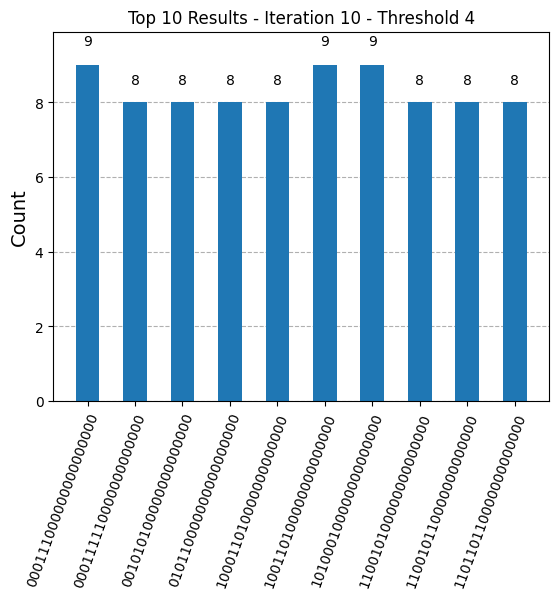

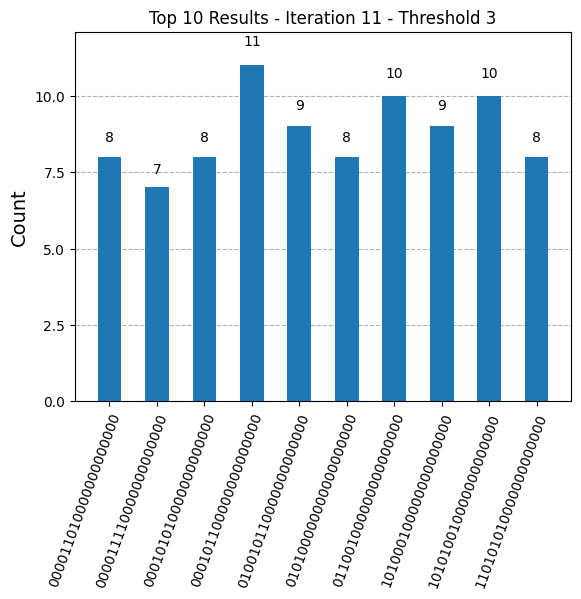

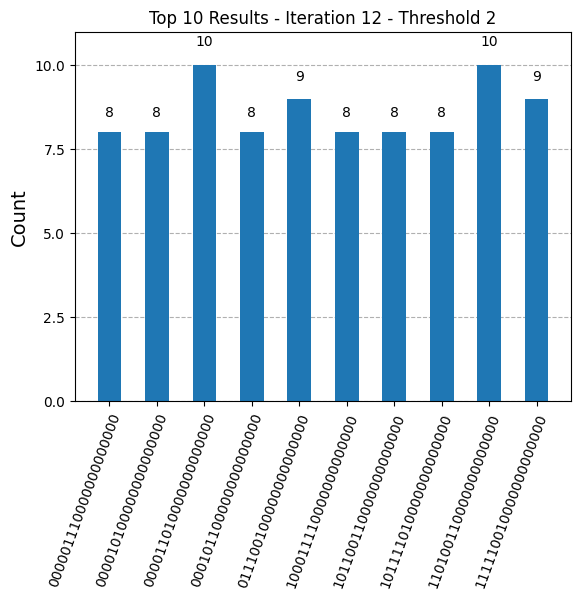

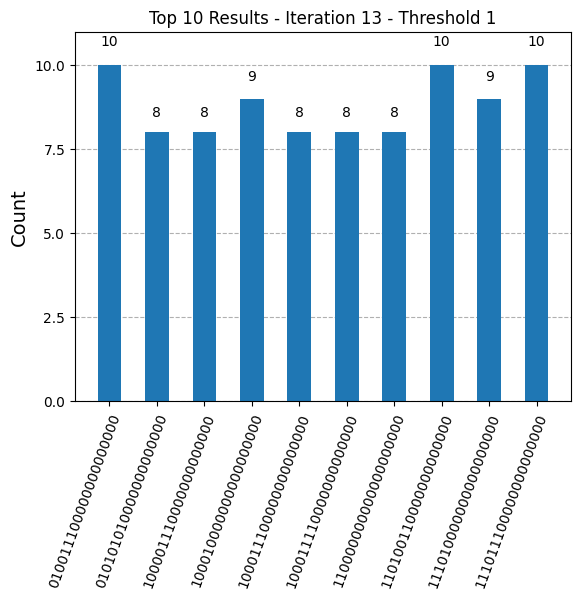

In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import GroverOperator
from hcd_clc_uncompute import create_hcd_clc_uncompute_oracle
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# --- Quantum Registers ---
t = 6
initial_threshold = 13
min_threshold = 1
max_iterations = initial_threshold - min_threshold + 1

backend = Aer.get_backend('qasm_simulator')

for iteration in range(max_iterations):
    threshold = initial_threshold - iteration

    # Quantum Registers
    precision = QuantumRegister(t, 't')        
    cth_flag = QuantumRegister(1, 'cth_flag')          
    hamiltonian_flag = QuantumRegister(1, 'hamiltonian_flag')
    ancillary = QuantumRegister(5, 'ancillary')
    cycle = QuantumRegister(8, 'C')            
    
    # Classical register to read outcome
    classical_bits = ClassicalRegister(len(cycle), 'c')
    
    # Oracle
    hcd_clc_uncompute_oracle = create_hcd_clc_uncompute_oracle(threshold)
    reflection_qubits = list(range(13, 21))  # assuming consistent qubit layout
    grover_op = GroverOperator(hcd_clc_uncompute_oracle, reflection_qubits=reflection_qubits)
    
    # Grover iteration circuit
    qc = QuantumCircuit(precision, cth_flag, hamiltonian_flag, ancillary, cycle, classical_bits)
    for i in reflection_qubits:
        qc.h(i)
    
    qc.compose(grover_op.power(8), inplace=True)
    qc.measure(cycle, classical_bits)

    # Run circuit
    compiled = transpile(qc, backend)
    result = backend.run(compiled, shots=1024).result()
    counts = result.get_counts()

    # Plot histogram
    # Sort counts by frequency, keep top N
    N = 10
    top_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True)[:N])

    # Plot histogram
    plot_histogram(top_counts, title=f"Top {N} Results - Iteration {iteration+1} - Threshold {threshold}")
    plt.show()

    #Find a logic to break the loop!

